# Week 6 Assignment

This week's assignment will be combining many of the concepts from weeks 5 and 6. Below, I've loaded the immunization dataset from week 5, minimally handled NaNs, separated continuous and categorical columns (somewhat harder to do than expected), and built a baseline RandomForestClassifier with a random column, as in week 5. My target column was FRSTBRN -- not a very interesting column, but it had no missing values... 

Your job is to use visualization to find important features, drop irrelevant features, and generally improve the classification.

**Note:** Be mindful when doing pair plots, correlation matrices, heatmaps, etc. The sheer number of columns will overwhelm your computer. ONLY do subsets of columns with these functions!

Pay special attention to:

* Handling NaN values
    * Determine which columns to keep & which to drop. 
        * For example: All data is from 2014, so the "YEAR" column might not be adding much to the analysis.
* Pair plots, heatmaps, facet grids, etc.
    * Choose plots from any 2 of the 3 charting libraries presented in the FTE.
* Documentation -- 
    * What do the pretty pictures **mean**? 
    * How does this help you decide what features are important?

*** 

Altair gallery: https://altair-viz.github.io/gallery/ <br>
Seaborn gallery: https://seaborn.pydata.org/examples/index.html <br>
Matplotlib gallery: https://matplotlib.org/3.1.1/gallery/index.html <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

In [2]:
# now we won't need to use plt.show() throguhtout this notebook
%matplotlib inline

In [3]:
# setting the aesthetics for seaborn
sns.set()

In [4]:
df = pd.read_csv("data/nispuf14.csv", na_values=['.'], low_memory=False)

In [5]:
df.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,.,.,218.30024855484000,218.300249,1022,2014,NaN,...,,,,.,.,.,.,.,.,.
1,21,2,1,806.84601169505000,806.84601169505000,454.86041741251200,454.860417,2036,2014,NaN,...,,,,2,.,.,2,2,2,.
2,31,3,2,.,.,30.54542540283290,30.545425,1072,2014,NaN,...,,,,.,.,.,.,.,.,.
3,41,4,1,63.44868567610260,63.44868567610260,36.96593137368630,36.965931,2016,2014,NaN,...,,,,1,2,2,.,2,2,2
4,51,5,1,94.87263225744540,94.87263225744540,64.62020426239790,64.620204,1073,2014,NaN,...,,,,2,1,1,.,2,2,77


In [6]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
df.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,NaN,NaN,218.300249,218.300249,1022,2014,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,2,1,806.846012,806.846012,454.860417,454.860417,2036,2014,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,2.0,2.0,NaN
2,31,3,2,NaN,NaN,30.545425,30.545425,1072,2014,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41,4,1,63.448686,63.448686,36.965931,36.965931,2016,2014,NaN,...,NaN,NaN,NaN,1.0,2.0,2.0,NaN,2.0,2.0,2.0
4,51,5,1,94.872632,94.872632,64.620204,64.620204,1073,2014,NaN,...,NaN,NaN,NaN,2.0,1.0,1.0,NaN,2.0,2.0,77.0


<div class="alert alert-block alert-info">
<b>Pop Quiz::</b> Why are we making a copy of the df at this point and not just using the original?
</div>

In [8]:
df_copy = df.copy()

In [9]:
from PyPDF2 import PdfFileReader
from PyPDF2.pdf import Destination  # read the pdf file

In [10]:
pdf_file = 'data/NISPUF14_CODEBOOK.PDF'

In [11]:
reader = PdfFileReader(pdf_file)
outlines = reader.outlines

I notice the PDF's outline tells us which variables are continuous. I would like to be able to read that outline and get those variables. Unfortunately, the PDF outline format is not terribly conducive to this operation.

<img src="figures_6/pdf_continuous.png" width=800><br>

As you can see, in the outlne "tree", when we see the text "Continuous Statistics", we need the **previous** entry, but PDF outlines are weird mixes of dictionaries and lists. I finally found the following answer on StackOverflow that satisfied the need. 

From https://stackoverflow.com/questions/1011938/python-previous-and-next-values-inside-a-loop

In [12]:
from itertools import tee, islice, chain

def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

Testing if I could find the word "Contnuous" in the PDF outline.

In [13]:
'Continuous' in outlines[7][0].title

True

In [14]:
cont_list = []
for prev, item, nxt in previous_and_next(outlines):
    if isinstance(item, list) :
        if 'Continuous' in str(item[0].title):
            cont_list.append(prev.title)

In [15]:
cont_list[:5]

['PROVWT_D', 'PROVWT_D_TERR', 'RDDWT_D', 'RDDWT_D_TERR', 'BF_ENDR06']

In [16]:
cat_list = [c for c in df_copy.columns if c not in cont_list]

#### Cleaning up the missing values
For categories, fill with -999 <br>
For continuous, fill with mean.

```
If your columns are a string then use :
df[ ' string column name' ].fillna(-999, inplace = True)

If your columns are not a string then use :
df[ ' column name ' ].fillna(df[ ' column name ' ].mean() , inplace = True)
```

In [17]:
for col in cat_list:
    df_copy[col].fillna(-999, inplace=True)

In [18]:
for col in cont_list:
    df_copy[col].fillna(df[col].mean(), inplace=True)

In [19]:
df_copy2 = df_copy.copy()
df_copy.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,383.438950,382.821312,218.300249,218.300249,1022,2014,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,21,2,1,806.846012,806.846012,454.860417,454.860417,2036,2014,-999.0,...,-999.0,-999.0,-999.0,2.0,-999.0,-999.0,2.0,2.0,2.0,-999.0
2,31,3,2,383.438950,382.821312,30.545425,30.545425,1072,2014,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,41,4,1,63.448686,63.448686,36.965931,36.965931,2016,2014,-999.0,...,-999.0,-999.0,-999.0,1.0,2.0,2.0,-999.0,2.0,2.0,2.0
4,51,5,1,94.872632,94.872632,64.620204,64.620204,1073,2014,-999.0,...,-999.0,-999.0,-999.0,2.0,1.0,1.0,-999.0,2.0,2.0,77.0


## Random Forest Classifier Benchmark

My target is going to be FRSTBRN -- FIRST BORN STATUS OF CHILD.

1 - No<br>
2 - Yes



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<div class="alert alert-block alert-info">
<b>Pop Quiz::</b> Do you know what the following does? 
</div>

In [21]:
np.random.seed(42)

In [22]:
y = df_copy['FRSTBRN']
X = df_copy.drop('FRSTBRN', axis=1)

I'm going to get the min and max values from one of the continuous variables to use as the min/max for the random column. 

In [23]:
the_min = X.PROVWT_D.min()
the_max = X.PROVWT_D.max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [24]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [25]:
clf=RandomForestClassifier(n_estimators=100)

In [26]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
y_pred=clf.predict(x_test)

In [28]:
from sklearn import metrics

In [29]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8832663989290496


#### Feature Importance

In [30]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )



Feature ranking:
1. feature CHILDNM   	27.04%
2. feature C1R   	15.07%
3. feature random   	1.72% <==
4. feature SEQNUMC   	1.61%
5. feature RDDWT_D_TERR   	1.59%
6. feature SEQNUMHH   	1.58%
7. feature RDDWT_D   	1.53%
8. feature STRATUM   	1.46%
9. feature INCPORAR   	1.41%
10. feature M_AGEGRP   	1.32%
11. feature BF_ENDR06   	1.27%
12. feature EST_GRANT   	1.27%
13. feature ESTIAP14   	1.24%
14. feature STATE   	1.18%
15. feature BF_FORMR08   	1.06%
16. feature INCQ298A   	1.02%
17. feature BF_EXCLR06   	0.99%
18. feature NUM_CELLS_HH   	0.74%
19. feature AGEGRP   	0.70%
20. feature EDUC1   	0.66%
21. feature D6R   	0.61%
22. feature PROVWT_D   	0.60%
23. feature PROVWT_D_TERR   	0.58%
24. feature INCPOV1   	0.58%
25. feature C5R   	0.56%
26. feature DDTP4   	0.51%
27. feature CEN_REG   	0.51%
28. feature INTRP   	0.50%
29. feature DVRC1   	0.49%
30. feature NUM_CELLS_PARENTS   	0.49%
31. feature DHEPB2   	0.48%
32. feature DHIB3   	0.48%
33. feature DDTP3   	0.48%
34. feature DFLU

Hmmm... Our random number turns out to be the third most important feature for my target variable of FRSTBRN.  That's kindda sad! Lesson of the day, choose your variables wisely.

## Week 6 Deliverable:

* Choose your own categorical variable (or one of the continuous ones if you feel brave).
* Do a correlation matrix to find variable relationships that have a high probability of correlation.
* Reduce the dataset to only include correlated variables from above.
* Complete EDA using the FTE as a baseline -- feel free to add your own tests.
    * Choose plots from any 2 of the 3 charting libraries presented in the FTE.
    * Or substitute a library of your own if you have experience with something else.
* Based on EDA results, either
    * Go back for more variables, or
    * Drop more variables
* Do some machine learning algorithm against your target variable
    * RandomForestClassifier (lke the FTE and above) if you haven't had experience with Machine Learning yet, or
    * Choose your favorite algorithm based on variable type
* Summary of your findings. For example, my FRSTBRN investigation shows the top 2 variables for determining whether a child is firstborn are:
    * CHILDNM -- Number of children in the household, and
    * C1R  -- Number of people in the household.
    

YES - 1 <br>
NO - 2 <br>
NEVER HEARD OF WIC - 3 <br>

RESERVED CODES:<br>
DON'T KNOW - 77 <br>
REFUSED 99 - 5 <br>

In [31]:
df_copy2['CWIC_01'].value_counts()

2     13470
1     11290
77       81
3        51
99        5
Name: CWIC_01, dtype: int64

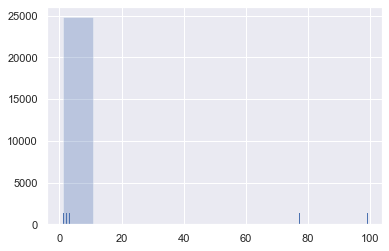

In [32]:
plt.hist(df_copy2.CWIC_01, alpha=.3)
sns.rugplot(df_copy2.CWIC_01)

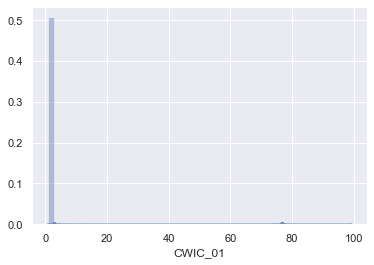

In [33]:
sns.distplot(df_copy2.CWIC_01)

In [34]:
CWIC = df_copy2['CWIC_01']
df_copy2.groupby('CWIC_01').sum()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
CWIC_01,,,,,,,,,,,,,,,,,,,,,
1,1358449933,135843808,15509,4.966189e+06,4.957537e+06,3.291136e+06,3.243361e+06,18448582,22738060,-11141500.0,...,-11278710.0,-11278710.0,-11278710.0,-3050994.0,-6283220.0,-6517319.0,-8074195.0,-3319744.0,-3100239.0,-3473484.0
2,1601848221,160183428,19007,4.517604e+06,4.510929e+06,2.489636e+06,2.482837e+06,21143593,27128580,-13292296.0,...,-13456530.0,-13456530.0,-13456530.0,-4317175.0,-8010168.0,-8033393.0,-9767845.0,-4353338.0,-4335836.0,-4611147.0
3,5969256,596920,78,2.150951e+04,2.149283e+04,8.579649e+03,8.579649e+03,79884,102714,-47942.0,...,-50949.0,-50949.0,-50949.0,-15941.0,-34937.0,-35935.0,-31933.0,-16842.0,-16921.0,-17917.0
77,8461343,846126,131,3.925976e+04,3.922888e+04,2.422100e+04,2.422100e+04,133958,163134,-78915.0,...,-80919.0,-80919.0,-80919.0,-39666.0,-56751.0,-56750.0,-63608.0,-39728.0,-39736.0,-48738.0
99,683065,68306,10,1.917195e+03,1.914107e+03,5.907885e+03,5.907885e+03,8192,10070,-4995.0,...,-4995.0,-4995.0,-4995.0,-4995.0,-4995.0,-4995.0,-4995.0,-4995.0,-4995.0,-4995.0


In [35]:
#Variable: CWIC_01 Type: Numeric Position: 135-136
#Label: CHILD EVER RECEIVED WIC BENEFITS? 
df_copy['CWIC_01']

0        2
1        2
2        1
3        2
4        1
        ..
24892    1
24893    2
24894    2
24895    2
24896    2
Name: CWIC_01, Length: 24897, dtype: int64

In [36]:
y = df_copy2['CWIC_01']
X = df_copy2.drop('CWIC_01', axis=1)

In [37]:
the_min = X.EDUC1.min()
the_max = X.EDUC1 .max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [38]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [39]:
clf=RandomForestClassifier(n_estimators=100)

In [40]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
y_pred=clf.predict(x_test)

In [42]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.9921017402945114


In [43]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )



Feature ranking:
1. feature CWIC_02   	32.34%
2. feature INCPORAR   	9.90%
3. feature INCQ298A   	6.44%
4. feature INCPOV1   	5.40%
5. feature EDUC1   	3.44%
6. feature MARITAL2   	3.06%
7. feature INS_1   	2.87%
8. feature M_AGEGRP   	2.05%
9. feature RENT_OWN   	1.49%
10. feature NUM_CELLS_PARENTS   	1.26%
11. feature INS_2   	1.16%
12. feature RACEETHK   	1.06%
13. feature BF_ENDR06   	1.02%
14. feature INS_3A   	0.91%
15. feature RDDWT_D   	0.85%
16. feature RDDWT_D_TERR   	0.79%
17. feature C5R   	0.77%
18. feature I_HISP_K   	0.77%
19. feature BF_FORMR08   	0.76%
20. feature LANGUAGE   	0.72%
21. feature SEQNUMHH   	0.72%
22. feature EST_GRANT   	0.72%
23. feature random   	0.71% <==
24. feature SEQNUMC   	0.69%
25. feature C1R   	0.69%
26. feature STATE   	0.68%
27. feature STRATUM   	0.67%
28. feature ESTIAP14   	0.66%
29. feature RACE_K   	0.50%
30. feature NUM_CELLS_HH   	0.49%
31. feature BF_EXCLR06   	0.48%
32. feature CBF_01   	0.44%
33. feature CEN_REG   	0.38%
34. featur

After looking at the top features from the Decision tree the top factor in deciding if a child has ever received WIC Benefits is CWIC_02 which is if the child currently receiving WIC Benefits which is a strong indicator if a child has ever received WIC. Let's remove this feature and see how accurate the Decision Tree becomes.

In [67]:
X.drop(['CWIC_01'], axis=1, inplace=True)

In [68]:
the_min = X.EDUC1.min()
the_max = X.EDUC1 .max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [69]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [71]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [72]:
y_pred=clf.predict(x_test)

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8753681392235609


99.21 to 87.54 is a big decrease but still a great Accuracy rate but it's still great accuracy without using the CWIC_02 feature!

In [75]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )

Feature ranking:
1. feature INCPORAR   	12.22%
2. feature INCQ298A   	7.21%
3. feature INCPOV1   	7.19%
4. feature EDUC1   	6.08%
5. feature MARITAL2   	4.07%
6. feature INS_1   	3.09%
7. feature RENT_OWN   	2.69%
8. feature M_AGEGRP   	2.40%
9. feature BF_ENDR06   	1.92%
10. feature RDDWT_D   	1.61%
11. feature INS_2   	1.52%
12. feature RDDWT_D_TERR   	1.52%
13. feature NUM_CELLS_PARENTS   	1.51%
14. feature SEQNUMC   	1.43%
15. feature random   	1.43% <==
16. feature SEQNUMHH   	1.41%
17. feature EST_GRANT   	1.36%
18. feature STRATUM   	1.35%
19. feature INS_3A   	1.32%
20. feature STATE   	1.31%
21. feature ESTIAP14   	1.30%
22. feature BF_FORMR08   	1.22%
23. feature C1R   	1.13%
24. feature RACEETHK   	1.11%
25. feature NUM_CELLS_HH   	1.05%
26. feature C5R   	1.03%
27. feature BF_EXCLR06   	0.97%
28. feature CBF_01   	0.90%
29. feature I_HISP_K   	0.83%
30. feature CEN_REG   	0.72%
31. feature RACE_K   	0.69%
32. feature LANGUAGE   	0.63%
33. feature D6R   	0.57%
34. feature CH

* Top two features
    * INCPORAR -- INCOME TO POVERTY RATIO. Determined from family income, number of persons in the household, number of children in the household, and the 2013 Census poverty thresholds. If any of the first three variables are missing then INCPORAR will be missing. 
    * INCQ298A -- FAMILY INCOME CATEGORIES. Family income in 2013.
    

Both of these fields make sense that they are the top two indicators for CWIC_01 and are the top indicators for CWIC_02.

In [76]:
from operator import itemgetter
#'CWIC_01'
#creating a list of the top 20 features for graphing.
sort = sorted(feature_rank, key=itemgetter(1))
#reverse list so the more important feature is at the beginning of the list
sort = sort[::-1]
#taking the first 20
sort = sort[:20]

In [79]:
#list comprehension to create a list of the top 20 features 
graph = [x[0] for x in sort if x[0] !='random']
# add CWIC_01 to the list of top features
graph.extend(['CWIC_01'])
#Create a dataframe that only contains the top20 features
df_graph = df_copy2[graph]


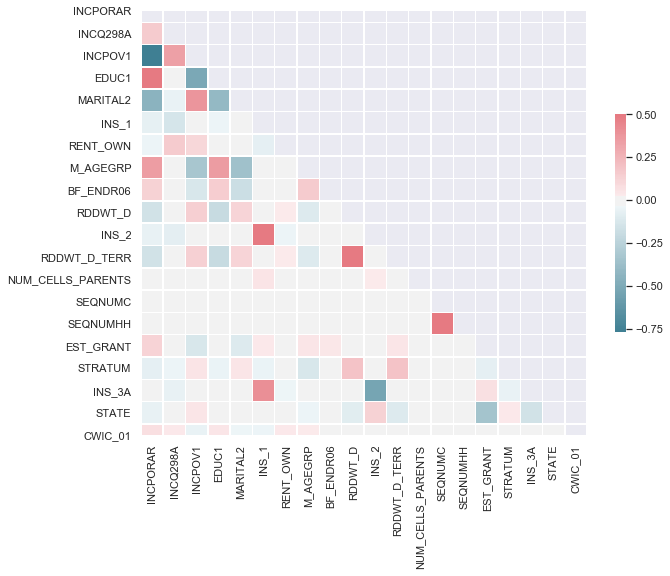

In [80]:
# Compute the correlation matrix
corr = df_graph.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [81]:
def heatMap(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

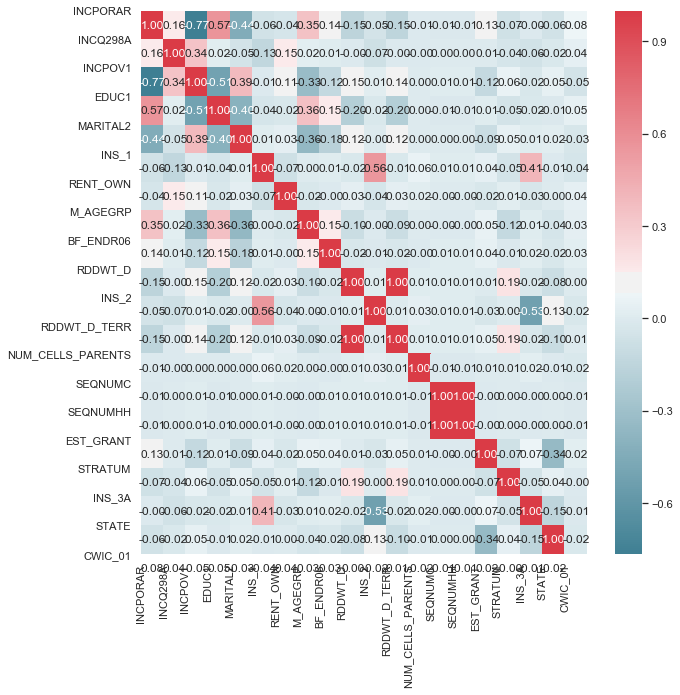

In [82]:
heatMap(df_graph)